In [1]:
import numpy as np
import matplotlib.pyplot as plt

import uproot
import awkward as ak
import pandas as pd
import hist
from hist import Hist

import torch
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import re

In [2]:
file = uproot.open("toy_hist.root")

In [3]:
def get_matrix(hist2D): 
    matrix , edge1, edge2 = hist2D.to_numpy()
    scaler = StandardScaler()
    matrix_scale = scaler.fit_transform(matrix)
    
    return matrix_scale

In [4]:
class data_set(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = torch.Tensor(images)
        self.labels = torch.Tensor(labels)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [5]:
X, y = [], []

for item in file:
    X.append(get_matrix(file[item].to_hist()))
    p = re.compile(r'\d+\.\d+')
    y.append([float(i) for i in p.findall(item)])
    
X = np.array(X)
y = np.array(y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)

In [7]:
print("*** train data set shape : inputs = {} & target = {}".format(X_train.shape, y_train.shape))
print("*** validation data set shape : inputs = {} & target = {}".format(X_val.shape, y_val.shape))

*** train data set shape : inputs = (42000, 20, 20) & target = (42000, 3)
*** validation data set shape : inputs = (18000, 20, 20) & target = (18000, 3)


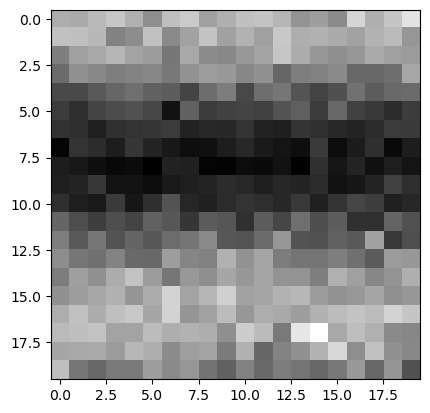

In [8]:
plt.imshow(X_train[0], cmap='gray')
plt.savefig("imgs/gray_toy.png")

In [9]:
batch_size = 15

train_dataloader = DataLoader(
    data_set(
        torch.Tensor(X_train).unsqueeze(1),
        torch.Tensor(y_train)
    ),
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    data_set(
        torch.Tensor(X_val).unsqueeze(1),
        torch.Tensor(y_val)
    ),
    batch_size=batch_size,
    shuffle=False
)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(16*3*3, 120)
        # self.dropout = torch.nn.Dropout(p=0.2)
        # self.fc2 = torch.nn.Linear(250, 120)
        self.fc3 = torch.nn.Linear(120, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*3*3)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        x = self.fc3(x)
        return x

In [11]:
net = CNN()

print(net)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=3, bias=True)
)


In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1.0e-03)
epochs = 50

In [14]:
loss = AverageMeter('Loss')
train_loss, val_loss = [], []

# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    # Set the model to training mode
    net.train()
    # Reset our meters
    loss.reset()

    # Iterate over batches
    for inputs, targets in train_dataloader:

        # Remove previous gradients
        optimizer.zero_grad()
        
        # Feed forward the input
        outputs = net(inputs)

        # Compute the loss and accuracy
        loss_batch = criterion(outputs, targets)
        loss.update(loss_batch.data)

        # Compute the gradients
        loss_batch.backward()

        # Update parameters
        optimizer.step()
        
    train_loss.append(loss.avg)
    
    # Validation for each epoch
    net.eval()
    loss.reset()

    for inputs, targets in val_dataloader:

        outputs = net(inputs)

        loss_batch = criterion(outputs, targets)
        loss.update(loss_batch.data)

    val_loss.append(loss.avg)

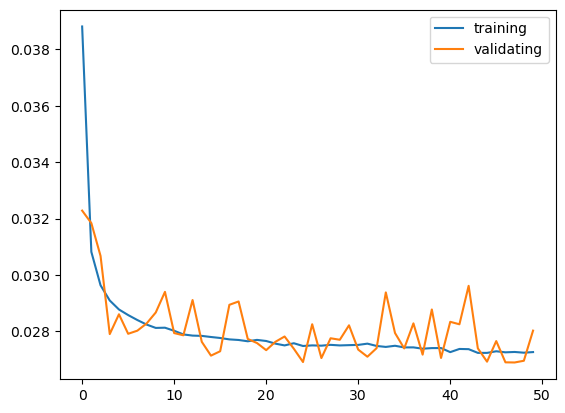

In [15]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validating')
plt.legend()
plt.savefig("imgs/loss_toy.png")

In [16]:
file2 = uproot.open("test_toy.root")

X_test = []

for item in file2:
    X_test.append(get_matrix(file2[item].to_hist()))

    
X_test = np.array(X_test)

In [17]:
net.eval()

results = net(torch.Tensor(X_test).unsqueeze(1)).detach().numpy()

lam = np.mean(results[:, 0])
lam_std = np.std(results[:, 0])

mu = np.mean(results[:, 1])
mu_std = np.std(results[:, 1])

nu = np.mean(results[:, 2])
nu_std = np.std(results[:, 2])

print("lambda = {:.4f} +/- {:.4f}".format(lam, lam_std))
print("mu = {:.4f} +/- {:.4f}".format(mu, mu_std))
print("nu = {:.4f} +/- {:.4f}".format(nu, nu_std))

lambda = 0.6492 +/- 0.0098
mu = 0.4881 +/- 0.0620
nu = 0.2280 +/- 0.0686
